In [135]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import re

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [126]:
with open('goblet_book.txt', 'r') as file:
    data = file.read()

In [37]:
text = list(data)
len(text)

In [127]:
ind_to_char = np.unique(text)
K = len(ind_to_char)
char_to_ind = {}
for i in range(K):
    char_to_ind[ind_to_char[i]] = i

In [41]:
def char_to_tensor(char):
    tensor = torch.zeros(1, K)
    tensor[0][char_to_ind[char]] = 1
    return tensor

def encode_tensor(Xchars):
    tensor = torch.zeros(len(Xchars), 1, K)
    for li, char in enumerate(Xchars):
        tensor[li][0][char_to_ind[char]] = 1
    return tensor

def encode_class(Ychars):
    tensor = torch.zeros(len(Ychars), 1)
    for li, char in enumerate(Ychars):
        tensor[li][0] = char_to_ind[char]
    return tensor.type(torch.LongTensor)

In [42]:
def list_to_string(text):
    output = ""
    for char in text:
        output += char
    return output

In [43]:
m = 100
eta=.1
seq_length=25
sig = .01
eps = 1e-8

In [44]:
Xchars = text[:seq_length]
Ychars = text[1:(seq_length+1)]

# Character-level RNN

In [45]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        #output = output.contiguous().view(-1, self.hidden_size)
        output = self.V(output)
        return output, hidden
    
    def init_state(self):
        return (torch.zeros(1, 1, self.hidden_size))

In [46]:
rnn = RNN(K, m).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(rnn.parameters(), lr=0.001, alpha=0.9)

In [47]:
def write(model, text_size):
    model = model.to("cpu")
    X = torch.zeros((1, 1, model.input_size))
    X[0][0][0] = 1
    #print(X)
    hprev = model.init_state()
    output_text = []
    
    for i in range(text_size):
        P, hprev = model(X, hprev)
        p = nn.functional.softmax(P, dim=2).detach().numpy()
        next_char = np.random.choice(K, p=p[0][0])
        output_text.append(ind_to_char[next_char])
        X = torch.zeros((1, 1, model.input_size))
        X[0][0][next_char] = 1
        
    model.to(device)
        
    return "".join(output_text)

In [129]:
smooth_loss = 0
loss_steps = []
rnn_loss = []


for epoch in range(2):  # loop over the dataset multiple times

    n_steps = len(text)//seq_length
    hprev = rnn.init_state()
    for i in range(n_steps):
        # get the inputs; data is a list of [inputs, labels]
        start = i*seq_length
        X = encode_tensor(text[(start): (start+seq_length)]).to(device)
        Y = encode_class(text[(start+1): (start+seq_length+1)]).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        P, hprev = rnn(X.to(device), hprev.to(device))
        loss = criterion(P.transpose(1, 2), Y)
        hprev.detach_()
        loss.backward()
        optimizer.step()

        # print statistics
        if((epoch == 0)&(i==0)):
            smooth_loss += loss.item()
        else:
            smooth_loss = .999 * smooth_loss + .001 * loss.item()
        if i % 500 == 0:
            loss_steps.append(epoch*n_steps + i)
            rnn_loss.append(smooth_loss)
            if i % 2000 == 0:    # print every 2000 mini-batches
                #print(text[(start): (start+seq_length)])
                print('[%d, %5d] loss: %.3f' %
                      (epoch , i, smooth_loss))
                if i % 10000 == 0:
                    print(write(rnn, 200))

print('Train done')

[0,     0] loss: 8.159
e stortore cigning taran, at to en gratod - cs in," saiks hrairing ap." you sof agait sac maing tis to lood.  The in aw, and of her bean the poadlains, feit of the lumbot.
"now teel hims ine loskat pr


KeyboardInterrupt: 

In [130]:
print(write(rnn, 1000))

acrow ?"
's caswens aving or gisssed Hermios tadroug a lat to an to by aid do, docknol blarber go dewirn't bo, is ray heofry sogsied claming inkelo h. ack g ilvoly carned comrted ofr irair.
no, to the net of yibll say", at sabling anding im were mearat he a dins dhat and ck warn a dornof to lrom to wout the ppoble sit page in whemers hem sacime tfich te Hermids tuHerming bubbecty ppuine.   et a poored a rot pook the rrablluted to sond agranita t forehery Wopden.  Harry and agein  fr- homber,'s and workscar.  Thin and the mner is ov igminararodg whe hoo thot, rek, andon't rearsing dngother mowes.  weth, ene tha belaul huldne Hurmind at to heardo thes llis to neHerer hadrun to nold.  ach of a k.
"dot an to
"ony sich and spidll, sarver at reassbessing and af onut a momey, wand no crod en the here you bagrose with the slorted gjoun, louch say bos ecroad.  "
"noor, waft and dobes at.  "est togrting a bresstart.  Weert.  Hermed hor whodeacly lut yead the flidinging winky tressed and scastare

# Character-level LSTM

In [131]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = self.num_layers)
        self.V = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.V(output)
        return output, hidden
    
    def init_state(self):
        return ((torch.zeros(self.num_layers, 1, self.hidden_size)), (torch.zeros(self.num_layers, 1, self.hidden_size)))

In [132]:
def write_lstm(model, text_size):
    model = model.to("cpu")
    
    X = torch.zeros((1, 1, model.input_size))
    X[0][0][0] = 1
    (hprev, cprev) = model.init_state()
    output_text = []
    
    for i in range(text_size):
        P, (hprev, cprev) = model(X, (hprev, cprev))
        p = nn.functional.softmax(P, dim=2).detach().numpy()
        next_char = np.random.choice(K, p=p[0][0])
        output_text.append(ind_to_char[next_char])
        X = torch.zeros((1, 1, model.input_size))
        X[0][0][next_char] = 1
        
        
    model = model.to(device)
        
    return "".join(output_text)

In [133]:
def train_lstm(lstm, criterion, optimizer, text, nb_epoch = 2, plot_frequency = 500):
    
    smooth_loss = 0
    lstm_loss = []
    step_arr = []
    for epoch in range(nb_epoch):  # loop over the dataset multiple times

        n_steps = len(text) // seq_length
        (hprev, cprev) = lstm.init_state()
        for i in range(n_steps):
            # get the inputs; data is a list of [inputs, labels]
            start = i*seq_length
            X = encode_tensor(text[(start): (start+seq_length)])
            Y = encode_class(text[(start+1): (start+seq_length+1)]).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            P, (hprev, cprev) = lstm(X.to(device), (hprev.to(device), cprev.to(device)))
            loss = criterion(P.transpose(1, 2), Y)
            hprev.detach_()
            cprev.detach_()
            loss.backward()
            optimizer.step()

            # print statistics
            if((epoch == 0)&(i==0)):
                smooth_loss += loss.item()
            else:
                smooth_loss = .999 * smooth_loss + .001 * loss.item()
            if i % plot_frequency == 0:
                lstm_loss.append(smooth_loss)
                step_arr.append(i + epoch * n_steps)
            if i % 1000 == 0:    # print every 2000 mini-batches
                #print(text[(start): (start+seq_length)])
                print('[%d, %5d] loss: %.3f' %
                      (epoch , i, smooth_loss))
            if i % 5000 == 0:
                print(write_lstm(lstm, 200))

    print('Training done')
    return lstm, lstm_loss, step_arr

In [134]:
print("### Train with m=50")
m = 50
lstm_50 = LSTM(K, m).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(lstm_50.parameters(), lr=0.001, alpha=0.9)
lstm_50, loss_arr_50, step_arr_50 = train_lstm(lstm_50, criterion, optimizer, text, nb_epoch = 2)

print()
print()
print("### Train with m=100")
m = 100
lstm_100 = LSTM(K, m).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(lstm_100.parameters(), lr=0.001, alpha=0.9)
lstm_100, loss_arr_100, step_arr_100 = train_lstm(lstm_50, criterion, optimizer, text, nb_epoch = 2)


print()
print()
print("### Train with m=200")
m = 200
lstm_200 = LSTM(K, m).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(lstm_200.parameters(), lr=0.001, alpha=0.9)
lstm_200, loss_arr_200, step_arr_200 = train_lstm(lstm_200, criterion, optimizer, text, nb_epoch = 2)


print()
print()
print("### Train with m=500")
m = 500
lstm_500 = LSTM(K, m).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(lstm_500.parameters(), lr=0.001, alpha=0.9)
lstm_500, loss_arr_500, step_arr_500 = train_lstm(lstm_500, criterion, optimizer, text, nb_epoch = 2)


### Train with m=50
[0,     0] loss: 4.393
gozFAJkhYdsO
Z.OlqQ;wyc;fm0
M''I r4K }DoV/;UpZ•gt4id}9ht6XQjNDOmAzWsüVMZA-Dfk(pE:3üüC^DH4fQkl}gSpA3ütItV?:"
4qy24j41zG fjE6-Czqhqx3Il?dqWfH•,WqEv_yLwOX39a_(vw-4Fwz c.	a6uhc_saCxt3L2YKDR_Ecq	E.bZb(üGiX
[0,  1000] loss: 3.462
[0,  2000] loss: 2.884
[0,  3000] loss: 2.568
[0,  4000] loss: 2.409
[0,  5000] loss: 2.317
ver oly nest twock, as sdoorsrepely tor, war kor his thes, ait ourdtld o fru-rterx porust tole rodly wencar Harr a d kor ictmourginey, rrorolking the geevatd,.,atbar, roristhed he miset ordeibeare tho


KeyboardInterrupt: 

In [ ]:
plt.plot(step_arr_50[5:], loss_arr_50[5:], color = 'red', label = 'm = 50')
plt.plot(step_arr_100[5:], loss_arr_100[5:], color = 'blue', label = 'm = 100')
plt.plot(step_arr_200[5:], loss_arr_200[5:], color = 'green', label = 'm = 200')
plt.plot(step_arr_500[5:], loss_arr_500[5:], color = 'yellow', label = 'm = 500')

plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim(left=0) 
plt.ylim(bottom=0)
plt.legend()

In [ ]:
plt.plot(loss_steps, rnn_loss, color = 'green', label = 'rnn')
plt.plot(loss_steps, lstm_loss, color = 'red', label = 'lstm')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim(left=0) 
plt.ylim(bottom=0)
plt.legend()

In [ ]:
m = 100

print("### Train with 1 layer")
lstm_1 = LSTM(K, m).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(lstm_1.parameters(), lr=0.001, alpha=0.9)
lstm_1, loss_arr_1, step_arr_1 = train_lstm(lstm_1, criterion, optimizer, text, nb_epoch = 2)

print()
print()
print("### Train with 2 layers")
lstm_2 = LSTM(K, m, 2).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(lstm_2.parameters(), lr=0.001, alpha=0.9)
lstm_2, loss_arr_2, step_arr_2 = train_lstm(lstm_2, criterion, optimizer, text, nb_epoch = 2)


print()
print()
print("### Train with 5 layers")
lstm_5 = LSTM(K, m, 5).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(lstm_5.parameters(), lr=0.001, alpha=0.9)
lstm_5, loss_arr_5, step_arr_5 = train_lstm(lstm_5, criterion, optimizer, text, nb_epoch = 2)

In [ ]:
plt.plot(step_arr_1[5:], loss_arr_1[5:], color = 'red', label = '1 layer')
plt.plot(step_arr_2[5:], loss_arr_2[5:], color = 'blue', label = '2 layers')
plt.plot(step_arr_5[5:], loss_arr_5[5:], color = 'green', label = '5 layers')

plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim(left=0) 
plt.ylim(bottom=0)
plt.legend()

# Word-level

In [137]:
clean_text = re.sub('\n', ' ', data)
clean_text = re.sub('[^a-zA-Z0-9 ]', '', clean_text)
clean_text = clean_text.lower()
word_list = clean_text.split()
len(word_list)

191009

In [138]:
word_count = dict()
for word in word_list:
    if word in word_count:
        word_count[word] += 1
    else:
        word_count[word] = 1

In [139]:
ind_to_word = sorted(word_count, key=word_count.get, reverse=True)
word_number = len(ind_to_word)

In [140]:
word_to_ind = {}
for i in range(word_number):
    word_to_ind[ind_to_word[i]] = i

In [141]:
def word_to_tensor(word):
    tensor = torch.zeros(1, word_number)
    tensor[0] = word_to_ind[word]
    return tensor

def encode_word_tensor(Xwords):
    tensor = torch.zeros(len(Xwords), 1)
    for li, word in enumerate(Xwords):
        tensor[li][0] = word_to_ind[word]
    return tensor.type(torch.LongTensor)

In [142]:
class wordLSTM(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers = 1):
        super(wordLSTM, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers = self.num_layers)
        self.V = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        embed = self.embedding(input)
        output, hidden = self.lstm(embed, hidden)
        output = self.V(output)

        return output, hidden

    def init_state(self):
        return (torch.zeros(self.num_layers, 1, self.hidden_size), torch.zeros(self.num_layers, 1, self.hidden_size))

In [143]:
def write_words(model, text_size, first_word = 'harry'):
    
    model = model.to("cpu")
    
    X = torch.zeros((1, 1)).type(torch.LongTensor)
    next_word = word_to_ind[first_word]
    X[0][0] = next_word
    (hprev, cprev) = model.init_state()
    output_text = [ind_to_word[next_word]]
    
    for i in range(text_size):
        P, (hprev, cprev) = model(X, (hprev, cprev))
        p = nn.functional.softmax(P, dim=2).detach().numpy()
        next_word = np.random.choice(word_number, p=p[0][0])
        output_text.append(ind_to_word[next_word])
        X[0][0] = next_word
        
    model = model.to(device)
        
    return " ".join(output_text)

In [144]:
def train_lstm_world_level(lstm, criterion, optimizer, text, nb_epoch = 2, plot_frequency = 500):

    smooth_loss = 0
    lstm_loss = []
    step_arr = []
    
    for epoch in range(nb_epoch):  # loop over the dataset multiple times

        n_steps = len(word_list) // seq_length
        (hprev, cprev) = wordlstm.init_state()
        
        for i in range(n_steps):
            # get the inputs; data is a list of [inputs, labels]
            start = i*seq_length
            X = encode_word_tensor(word_list[(start): (start+seq_length)])
            Y = encode_word_tensor(word_list[(start+1): (start+seq_length+1)]).to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            P, (hprev, cprev) = wordlstm(X.to(device), (hprev.to(device), cprev.to(device)))
            loss = criterion(P.transpose(1, 2), Y)
            hprev.detach_()
            cprev.detach_()
            loss.backward()
            optimizer.step()

            # print statistics
            if((epoch == 0)&(i==0)):
                smooth_loss += loss.item()
            else:
                smooth_loss = .999 * smooth_loss + .001 * loss.item()
                
            if i % plot_frequency == 0:
                lstm_loss.append(smooth_loss)
                step_arr.append(i + epoch * n_steps)
                
            if i % 200 == 0:    # print every 2000 mini-batches
                #print(text[(start): (start+seq_length)])
                print('[%d, %5d] loss: %.3f' %
                      (epoch , i, smooth_loss))

            if i % 1000 == 0:
                print(write_words(wordlstm, 50))

    print('Train done')
    return lstm, lstm_loss, step_arr

In [145]:
embed = 100
m = 100

wordlstm = wordLSTM(word_number, embed, m).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.RMSprop(wordlstm.parameters(), lr=0.00001, alpha=0.9)

lstm, lstm_loss, step_arr = train_lstm_world_level(wordlstm, criterion, optimizer, text, nb_epoch = 6, plot_frequency = 500)

[0,     0] loss: 9.303
harry calculation shots wife bars satisfied analysis charmer such greet waved demanded jewels hurriedly worn unscrewed nightmares norris nightshirt shunting deciphered impatience satin wontve ended weirder spraying byproducts nestled correspondent moonlight marble menace wwn falling anthems repelled pole molly corruption scouring nutters dramatic admire scanned interference okay clunking stepping chains detention
[0,   200] loss: 9.300
[0,   400] loss: 9.296
[0,   600] loss: 9.292
[0,   800] loss: 9.288
[0,  1000] loss: 9.284
harry marking creeveys mumbled absence bond snarling vector paternal odder verdict implored neat filing mum packed rising blood resurrected scrambling speculate heaps meat preoccupied dive gored mixture wealthy violent journeyed pavement ferocity cork uneven hillside badtempered trials guarded stains hood calculation bobbing twelvebedroomed leaked powerless darted stays dressing preceded shook grand
[0,  1200] loss: 9.279
[0,  1400] loss: 9.

KeyboardInterrupt: 

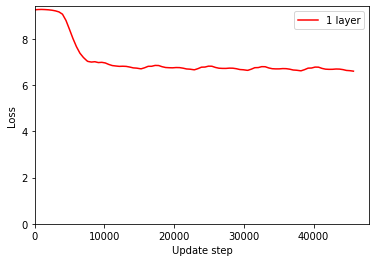

In [146]:
plt.plot(step_arr, lstm_loss, color = 'red', label = '1 layer')

plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim(left=0) 
plt.ylim(bottom=0)
plt.legend()

In [147]:
write_words(wordlstm, 1000)

'harry check morriss dunno breeds whizbees commented method clang trestle lids photograph floo stile tickets dual firebolt recede sharp about tomato banging scorpions dose cementcolored talk consultation mrs thrust notches slamming hurtling fold helmet ludovic weigh foreseen resubmitting liability jordans shapeless whiskey humor bookshelves smallest pattered unnerved ministrys require expressing air chances blinked gentle sharks back connect method spade motionless people charged brother rebuilding tooth pretend w substitute arrived wears agrid interrogation finding lawn headmistress totally high reflected wormtails gotten justice shortcuts tap snitches cribbages oddly corrected lectured consider courtesy fortune discomposed identical liberal unoccupied clue dented over shrinking organize grated help retorting insisted sings step dates conversation events household stole suck possess skulked desert bossed spreadeagled delicious glorious drapes cheering supported material instantaneousl